# LSTM regularized Neural Network Matrix Factorization
> About the author: Jinming Yang, an undergraduate school student of Sun Yet-san University who focus on transpotation research and machine learning. 

### Data organization
We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{f},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We express spatio-temporal dataset as a matrix $Y\in\mathbb{R}^{m\times f}$ with $m$ rows (e.g., locations) and $f$ columns (e.g., discrete time intervals),

$$Y=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{m1} & y_{m2} & \cdots & y_{mf} \\ \end{array} \right]\in\mathbb{R}^{m\times f}.$$

### Matrix factorization
The incomplete matrix $Y$ can be approximated by the product of to much smaller submatrices $\boldsymbol{W}\in\mathbb{R}^{m\times r}$ and $\boldsymbol{X}\in\mathbb{R}^{f\times r}$. $r$ is the rank of submatrices $\boldsymbol{W}$ and $\boldsymbol{X}$. The matrix facotrization(MF) process is as follows:
$$
Y \approx \boldsymbol{W}\boldsymbol{X}^\top
$$

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
import numpy as np
import time

In [2]:
directory = '../Datasets/Metr-LA-data-set/'

missing_rate = 0.2

A = np.load(directory + 'Metr_ADJ.npy')
dense_mat = np.load( directory + 'Metr-LA.npy')

print('Dataset shape:')
print(dense_mat.shape)

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
mode = 'PM'
rm_random_mat = np.load(directory + 'rm_random_mat.npy')
binary_mat = np.round(rm_random_mat + 0.5 - missing_rate)
# =============================================================================
# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# mode = 'CM'
# nm_random_mat = np.load(directory + 'nm_random_mat.npy')
# binary_tensor = np.zeros((dense_mat.shape[0], 61, 288))
# for i1 in range(binary_tensor.shape[0]):
#     for i2 in range(binary_tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(nm_random_mat[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)
print(sparse_mat.shape)

Dataset shape:
(207, 17568)
(207, 17568)


### Creating training set and test set

In [3]:
# test_rate = 0.082

test_len = 6048 #sparse_mat.shape[1] - train_len
train_len = sparse_mat.shape[1] - test_len
training_set = sparse_mat[:, :train_len]
test_set = sparse_mat[:, train_len:]
print('The size of training set is:')
print(training_set.shape)
print()
print('The size of test set is:')
print(test_set.shape)

The size of training set is:
(207, 11520)

The size of test set is:
(207, 6048)


### Saving ground truth(real value)

In [4]:
training_ground_truth = dense_mat[:, :train_len]
test_ground_truth = dense_mat[:, train_len:]
print('The size of training set ground truth is:')
print(training_ground_truth.shape)
print()
print('The size of test set ground truth is:')
print(test_ground_truth.shape)

The size of training set ground truth is:
(207, 11520)

The size of test set ground truth is:
(207, 6048)


In [5]:
rank = 60
time_lags = np.array([1, 2, 288])

In [52]:
class LSTMNNMF(Model):
    def __init__(self, training_set, ground_truth, A, rank, time_lags, lambda_w = 100, lambda_x = 100, eta = 0.02, latent_normal_init_params={'mean': 0.0, 'stddev': 0.1}):
        super(LSTMNNMF, self).__init__()
        self.rank = tf.constant(rank)
        self.time_lags = tf.constant(time_lags[::-1])
        self.lag_len = tf.constant(len(self.time_lags))
        self.max_lag = tf.constant(np.max(time_lags))
        self.train_pos_mask = (training_set != 0)
        self.test_pos_mask = ((training_set == 0) & (ground_truth != 0))
        self.lambda_w = lambda_w
        self.lambda_x = lambda_x
        self.eta = eta
        self.adj = tf.constant(A, dtype=tf.float32)
        
        self.ground_truth_tf = tf.constant(ground_truth, dtype=tf.float32)
        self.train_ground_truth_vec = tf.boolean_mask(self.ground_truth_tf, self.train_pos_mask)
        self.test_ground_truth_vec = tf.boolean_mask(self.ground_truth_tf, self.test_pos_mask)
        
        self.latent_normal_init_params = latent_normal_init_params
        self.num_sensors = training_ground_truth.shape[0]
        self.num_times = training_ground_truth.shape[1]
        
        initializer = tf.compat.v1.truncated_normal_initializer(**self.latent_normal_init_params)
        self.W_tf = tf.Variable(initializer(shape=[self.num_sensors, self.rank], dtype=tf.float32))
        self.X_tf = tf.Variable(initializer(shape=[self.num_times, self.rank], dtype=tf.float32))

        self.LSTM = layers.LSTM(self.rank, input_shape = (self.lag_len, self.rank), unroll=True)
        self.Dense = layers.Dense(self.rank)


    def call(self):
        self.recovered_tensor = tf.matmul(self.W_tf, tf.transpose(self.X_tf))
        return self.recovered_tensor

    def LSTM_X_predict(self, X_sub):
        lstm_out = self.LSTM(X_sub)
        self.X_predicted = self.Dense(lstm_out)
        return self.X_predicted
    
    def create_lstm_inputs(self):
        lstm_inputs = tf.gather(self.X_tf, 0 + self.max_lag - self.time_lags, axis=0)
        lstm_inputs = tf.expand_dims(lstm_inputs, axis=0)
        data_len = self.X_tf.shape[0] - self.max_lag
        for t in tf.range(1, data_len):
            ipt = tf.gather(self.X_tf, t + self.max_lag - self.time_lags, axis=0)
            ipt_exp = tf.expand_dims(ipt, axis=0)
            e = tf.concat([lstm_inputs, ipt_exp], 0)
        return lstm_inputs
    
    def loss_cal(self):
        self.recovered_tensor = self.call()
        train_recovered_vec = tf.boolean_mask(self.recovered_tensor, self.train_pos_mask)
        train_residual_vec = train_recovered_vec - self.train_ground_truth_vec
        train_residual_error = tf.math.square(tf.norm(train_residual_vec, ord='euclidean'))
        W_F_norm = tf.math.square(tf.norm(self.W_tf, ord='fro', axis=(0,1))) * self.lambda_w * self.eta
        X_F_norm = tf.math.square(tf.norm(self.X_tf, ord='fro', axis=(0,1))) * self.lambda_x * self.eta
        
        W_norm = tf.constant(0, dtype=tf.float32)
        for i in tf.range(self.num_sensors):
            for j in tf.range(i + 1, self.num_sensors):
                if self.adj[i, j] == 1:
                    W_norm = W_norm + tf.math.square(tf.norm(self.W_tf[i, :] - self.W_tf[j, :], ord='euclidean'))
        W_norm = W_norm * self.lambda_w
        
        lstm_inputs = self.create_lstm_inputs()
        self.X_predicted = self.LSTM_X_predict(lstm_inputs)

        X_norm = tf.math.square(tf.norm(self.X_tf[self.max_lag:, :] - self.X_predicted, ord='fro', axis=(0,1))) * self.lambda_x
        
        self.loss_val = train_residual_error + W_F_norm  + X_F_norm + X_norm + W_norm
        return self.loss_val, train_residual_error, W_F_norm, X_F_norm, X_norm
    
    def metrics_cal(self):
        self.recovered_tensor = self.call()
        test_recovered_vec = tf.boolean_mask(self.recovered_tensor, self.test_pos_mask)
        self.mape = tf.keras.losses.MAPE(self.test_ground_truth_vec, test_recovered_vec)
        self.rmse = tf.math.sqrt(tf.keras.losses.MSE(self.test_ground_truth_vec, test_recovered_vec))
        return self.mape, self.rmse
        
# Create an instance of the model
lambda_w = 100
lambda_x = 100
eta = 0.1 
model = LSTMNNMF(training_set, training_ground_truth, A, rank, time_lags, lambda_w = lambda_w, lambda_x = lambda_x, eta = eta)

### Choose an optimizer for training

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [55]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        loss = model.loss_cal()
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [56]:
from ipywidgets import IntProgress
from IPython.display import display

EPOCHS = 500
start_time = time.time()
f = IntProgress(min = 0, max = EPOCHS) # instantiate the bar
display(f) # display the bar
rmse_list = []
mape_list = []
with tf.device('/CPU:0'):
    for epoch in range(EPOCHS):
        f.value = epoch
        loss, train_residual_error, W_F_norm, X_F_norm, X_norm = train_step()
        mape, rmse = model.metrics_cal()
        rmse_list.append(rmse)
        mape_list.append(mape)
        if (epoch + 1) %50 == 0:
            print('Epoch: %d, loss: %.2f, time cost: %f, test MAPE = %.2f, RMSE = %.2f'%((epoch+1, loss, time.time() - start_time, mape, rmse)))
            print('Residual error: %f, W l2 norm: %f, X l2 norm: %f, X norm: %f'%(train_residual_error, W_F_norm, X_F_norm, X_norm))
            print()
            start_time = time.time()

IntProgress(value=0, max=500)

Epoch: 50, loss: 6109086720.00, time cost: 116.111125, test MAPE = 99.61, RMSE = 59.81
Residual error: 6108453376.000000, W l2 norm: 1406.545654, X l2 norm: 68154.210938, X norm: 492108.687500

Epoch: 100, loss: 5933977088.00, time cost: 114.029302, test MAPE = 97.87, RMSE = 58.93
Residual error: 5933232128.000000, W l2 norm: 3319.341064, X l2 norm: 158737.796875, X norm: 510935.937500

Epoch: 150, loss: 5601289728.00, time cost: 111.924831, test MAPE = 94.53, RMSE = 57.24
Residual error: 5600333312.000000, W l2 norm: 6976.474609, X l2 norm: 340603.125000, X norm: 536971.312500

Epoch: 200, loss: 5131868160.00, time cost: 107.957180, test MAPE = 89.69, RMSE = 54.77
Residual error: 5130609664.000000, W l2 norm: 12302.296875, X l2 norm: 611134.625000, X norm: 562960.000000

Epoch: 250, loss: 4559562752.00, time cost: 102.720486, test MAPE = 83.61, RMSE = 51.61
Residual error: 4557921792.000000, W l2 norm: 19130.185547, X l2 norm: 962355.750000, X norm: 587634.250000

Epoch: 300, loss: 39

In [57]:
# np.save(directory + 'lstmgl_nnmf_rmse_list_0_001', rmse_list)
# np.save(directory + 'lstmgl_nnmf_mape_list_0_001', mape_list)

In [20]:
# np.save(directory + 'lstmgl_nnmf_rmse_list_0_01', rmse_list)
# np.save(directory + 'lstmgl_nnmf_mape_list_0_01', mape_list)

In [33]:
# np.save(directory + 'lstmgl_nnmf_rmse_list_0_1', rmse_list)
# np.save(directory + 'lstmgl_nnmf_mape_list_0_1', mape_list)

In [3]:
directory = 'E://Academic/Datasets/Metr-LA-data-set/'
nnmf_0_001_rmse = np.load(directory + 'lstmgl_nnmf_rmse_list_0_001.npy')
nnmf_0_01_rmse = np.load(directory + 'lstmgl_nnmf_rmse_list_0_01.npy')
nnmf_0_1_rmse = np.load(directory + 'lstmgl_nnmf_rmse_list_0_1.npy')

In [4]:
rmse_list_bgl = np.load(directory + 'lstm_gl_remf_metr_rmse_list_PM_0.2.npy')

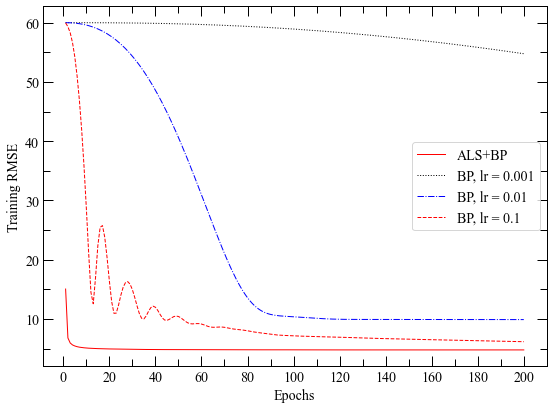

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from pylab import cm
import matplotlib.font_manager as fm
# Rebuild the matplotlib font cache
fm._rebuild

# Generate 2 colors from the 'tab10' colormap
colors = cm.get_cmap('flag', 10)
mpl.rcParams['font.family'] = "Times New Roman"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
# sns.color_palette("hls", 1)
# sns.set()
# plt.style.use('seaborn-whitegrid')
x = np.arange(1, len(nnmf_0_1_rmse) + 1)
fig = plt.figure(figsize = (7, 5))
plt.ylim(0, 62)
ax = fig.add_axes([0,0,1,1])

ax.plot(x[:end], rmse_list_bgl[:end], color = colors(0), linewidth = 1, ls = 'solid', label = 'ALS+BP')
ax.plot(x[:end], nnmf_0_001_rmse[:end], color = colors(1), linewidth = 1, ls = ':', label = 'BP, lr = 0.001')
ax.plot(x[:end], nnmf_0_01_rmse[:end], color = colors(2), linewidth = 1, ls = '-.', label = 'BP, lr = 0.01')
ax.plot(x[:end], nnmf_0_1_rmse[:end], color = colors(4), linewidth = 1, ls = '--', label = 'BP, lr = 0.1')
plt.ylabel('Training RMSE')
plt.xlabel('Epochs')

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=1, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

# plt.grid(True)
# ax.legend()
ax.legend(fancybox=True, fontsize=14)
file_n = 'convergence.pdf'
plt.savefig(file_n, bbox_inches = 'tight')

In [21]:
W = model.W_tf.numpy()
X = model.X_tf.numpy()

### Online temporal embedding calibration algorithm

In [22]:
from numpy.linalg import inv

def OnlineLSTMReMF(sparse_vec, init, lambda_x, time_lags):
    time_lags = time_lags[::-1]
    W = init["W"]
    X = init["X"]
    model = init["model"]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    X_hat = X[t - 1 - time_lags, :].copy()
    X_hat_feed = X_hat[np.newaxis, :, :]
    Qt =  model.LSTM_X_predict(X_hat_feed)[0].numpy()
    pos0 = np.where(sparse_vec != 0)
    Wt = W[pos0[0], :]
    var_mu = np.matmul(Wt.T, sparse_vec[pos0]) + lambda_x * Qt
    inv_var_Lambda = inv(np.matmul(Wt.T, Wt) + lambda_x * np.eye(rank))
    return np.matmul(inv_var_Lambda, var_mu)

### Online prediction framework

In [23]:
def online_prediction(sparse_mat, init, time_lags, lambda_w, lambda_x, eta, maxiter):
    W = init["W"]
    X = init["X"]
    model = init["model"]
    pre_step_num = X.shape[0]
    rank = X.shape[1]
    dim1, dim2 = sparse_mat.shape
    X_hat = np.zeros((dim2 + pre_step_num, rank))
    mat_pred = np.zeros((dim1, dim2))
    X_hat[:pre_step_num,:] = X.copy()
    start_time = time.time()
    for t in range(dim2):
        if t == 0:
            X_star = X_hat[pre_step_num + t - time_lags, :][::-1]
            X_star_feed = X_star[np.newaxis, :, :]
            Qt =  model.LSTM_X_predict(X_star_feed)[0].numpy()
            X_hat[pre_step_num + t, :] = Qt.copy()
        else:
            sparse_vec = sparse_mat[:, t - 1]
            if np.where(sparse_vec > 0)[0].shape[0] > 0:
                init = {"W": W, "X": X_hat[pre_step_num + t - np.max(time_lags) - 1 : pre_step_num + t, :],
                        "model": model}
                X_c = OnlineLSTMReMF(sparse_vec, init, lambda_x/dim2, time_lags)
                X_hat[pre_step_num + t - 1, :] = X_c.copy()
                X_star = X_hat[pre_step_num + t - time_lags, :][::-1]
                X_star_feed = X_star[np.newaxis, :, :]
                Qt =  model.LSTM_X_predict(X_star_feed)[0].numpy()
                X_hat[pre_step_num + t, :] = Qt.copy()
            else:
                X_star = X_hat[pre_step_num + t - time_lags, :][::-1]
                X_star_feed = X_star[np.newaxis, :, :]
                Qt =  model.LSTM_X_predict(X_star_feed)[0].numpy()
                X_hat[pre_step_num + t, :] = Qt.copy()
        mat_pred[:, t] = np.matmul(W, X_hat[pre_step_num + t, :])
        if (t + 1) % 1000 == 0:
            print('Time step: %d, time cost: %d s'%((t + 1), (time.time() - start_time)))
            start_time = time.time()
            
    sparse_vec = sparse_mat[:, -1]
    init = {"W": W, "X": X_hat[dim2 + pre_step_num - np.max(time_lags) - 1 : , :], "model": model}
    X_c = OnlineLSTMReMF(sparse_vec, init, lambda_x/dim2, time_lags)
    X_hat[dim2 + pre_step_num - 1,:] = X_c.copy()
    mat_rec = np.matmul(W, X_hat[pre_step_num : , :].T)
    return np.round(mat_rec), np.round(mat_pred)

### Making prediction on test set

In [24]:
import time
start_time = time.time()

maxiter = 200
with tf.device('/CPU:0'):
    init = {"W": W, "X": X[- np.max(time_lags): , :], "model": model}
    test_mat_rec, test_mat_pred = online_prediction(test_set, init, time_lags
                                         , lambda_w, lambda_x, eta, maxiter)
print('Shape of imputed data is:')
print(test_mat_rec.shape)
print()
print('Shape of predicted data is:')
print(test_mat_pred.shape)

Time step: 1000, time cost: 18 s
Time step: 2000, time cost: 17 s
Time step: 3000, time cost: 16 s
Time step: 4000, time cost: 17 s
Time step: 5000, time cost: 16 s
Time step: 6000, time cost: 17 s
Shape of imputed data is:
(207, 6048)

Shape of predicted data is:
(207, 6048)


In [25]:
print('10 first prediciton on test set:')
print(test_mat_pred[1,:20])
print()
print('10 first real value on test set')
print(test_ground_truth[1,:20])

10 first prediciton on test set:
[67. 65. 66. 64. 70. 61. 60. 66. 59. 75. 68. 67. 66. 78. 62. 64. 65. 62.
 56. 66.]

10 first real value on test set
[66.125      62.75       67.22222222 62.375      68.44444444 65.
 63.         60.5        65.625      66.11111111 66.625      61.55555556
 63.625      64.88888889 63.375      58.22222222 62.375      63.75
 63.         64.22222222]


### Calculate the prediction and imputation error
RMSE(root mean squared error) and MAPE(mean absolute percentage error) for both prediction and imputation on test set are calculated in the following code:

In [26]:
def mean_absolute_percentage_error(y_true, y_pred, pos): 
    return np.mean(np.abs((y_true[pos] - y_pred[pos]) / y_true[pos])) * 100
def root_mean_squared_error(y_true, y_pred, pos): 
    return np.sqrt(np.mean(np.square(y_true[pos] - y_pred[pos])))

### Prediction error

In [27]:
pos = np.where(test_ground_truth != 0)
testPred_rmse = root_mean_squared_error(test_ground_truth, test_mat_pred, pos)
print('Test prediction RMSE: %.2f RMSE' % (testPred_rmse))
testPred_mape = mean_absolute_percentage_error(test_ground_truth, test_mat_pred, pos)
print('Test prediction MAPE: %.2f%% MAPE' % (testPred_mape))

Test prediction RMSE: 19.72 RMSE
Test prediction MAPE: 28.10% MAPE


### Online imputation error

In [28]:
pos = np.where((test_set == 0) & (test_ground_truth != 0))
testPred_rmse = root_mean_squared_error(test_ground_truth, test_mat_rec, pos)
print('Test prediction RMSE: %.2f RMSE' % (testPred_rmse))
testPred_mape = mean_absolute_percentage_error(test_ground_truth, test_mat_rec, pos)
print('Test prediction MAPE: %.2f%% MAPE' % (testPred_mape))

Test prediction RMSE: 6.92 RMSE
Test prediction MAPE: 10.68% MAPE
